<a href="https://colab.research.google.com/github/piyushgoel997/MutationClassification/blob/master/Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import statements and declaring some global variables


In [1]:
import time
import random

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from keras.utils import plot_model
from sklearn.metrics import roc_curve, auc, precision_recall_curve, accuracy_score
from tensorflow.python.keras import Sequential
from tensorflow.python.keras.layers import Conv1D, BatchNormalization, GlobalMaxPooling1D
from tensorflow.keras.callbacks import EarlyStopping

data_url = "https://raw.githubusercontent.com/piyushgoel997/MutationClassification/master/data.csv"
epochs = 1000
batch_size = 8192

# to stop the model from overfitting on the training data.
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=50, verbose=2, mode="min", restore_best_weights=True)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


Load and represent data in a one-hot encoded matrix form to be easily able to train the model.

Matrix Dimentions: Number of examples, Number of Features (in this case, the length of the sequence of Amino Acids), Number of possible feature values (20 possible Amino Acids)

In [2]:
def get_aa_encoder():
    """
    One-hot encoding indices for the 20 possible amino acids.
    :return: the dictionary mapping amino acid to index in the one-hot encoding.
    """
    acids = "ARNDCEQGHILKMFPSTWYV"
    indices = {}
    i = 0
    for a in acids:
        indices[a] = i
        i += 1
    return indices


def make_matrix(seq, alt):
    """
    makes a matrix where each of the 51 features correspond to the amino acid at
    that position in the sequence after the one-hot encoding using the indices
    provided. Also puts a -1 at in the middle most feature at the position
    corresponding to the alt amino acid.
    :param seq: the sequence to be encoded.
    :param alt: the alternate amino acid
    :return: the resultant encoded matrix (51 X 20)
    """
    indices = get_aa_encoder()
    matrix = np.zeros((len(indices), len(seq)))
    i = 0
    for s in seq:
        matrix[indices[s]][i] = 1
        i += 1
    matrix[indices[alt]][int(len(seq) / 2)] = -1
    return matrix.T


def map_description(description):
    map = {'Benign': 0, 'Benign/Likely benign': 0, 'Likely benign': 0,
           'Likely pathogenic': 1, 'Pathogenic': 1, 'Pathogenic/Likely pathogenic': 1}
    return map[description]


def shuffle_together(arrays):
    ind = list(range(len(arrays[0])))
    random.shuffle(ind)
    return [X[ind] for X in arrays]


X = []
Y = []
gene_ids = []
mutations = pd.read_csv(data_url)

for _, row in mutations.iterrows():
    X.append(make_matrix(row["REF_SEQ"], row["ALT_AA"]))
    Y.append(map_description(row["DESCRIPTION"]))
    gene_ids.append(row["UNIPROT_ACCESSION"])

X = np.array(X)
Y = np.array(Y)

X, Y, gene_ids = shuffle_together([X, Y, np.array(gene_ids)])
gene_ids = list(gene_ids)

print("Input shape", X.shape, "\nOutput shape", Y.shape)
print("Count of Pathogenic examples", np.count_nonzero(Y == 1))
print("Count of Benign examples", np.count_nonzero(Y == 0))
print("Total number of genes present", len(set(gene_ids)))

Input shape (229502, 51, 20) 
Output shape (229502,)
Count of Pathogenic examples 41045
Count of Benign examples 188457
Total number of genes present 8203


Helper methods to be initialize and comple the model, and provide different evaluation metrics like accuracy, loss, ROC curve, ROC AUC, PRC curve, etc.

In [0]:
def get_model(h=0):
    """
    make, compile and return the model
    :param h: The number of hidden layers with 64 channels to be added
    :return: the model
    """
    model = Sequential()
    model.add(Conv1D(32, kernel_size=3, activation="relu"))
    for _ in range(h):
        model.add(Conv1D(64, kernel_size=5, activation="relu"))
        model.add(BatchNormalization())
    model.add(Conv1D(32, kernel_size=3, activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv1D(1, kernel_size=1, activation='sigmoid'))
    model.add(BatchNormalization())
    model.add(GlobalMaxPooling1D())
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
    return model


def get_model2(h):
    """
    make, compile and return the model. Incresed the kernel size.
    :param h: The number of hidden layers with 64 channels to be added
    :return: the model
    """
    model = Sequential()
    model.add(Conv1D(32, kernel_size=5, activation="relu"))
    for _ in range(h):
        model.add(Conv1D(64, kernel_size=7, activation="relu"))
        model.add(BatchNormalization())
    model.add(Conv1D(32, kernel_size=5, activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv1D(1, kernel_size=1, activation='sigmoid'))
    model.add(BatchNormalization())
    model.add(GlobalMaxPooling1D())
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
    return model


def k_fold_cross_validation(h, X, Y, k=10, epochs=20, batch_size=512, callbacks=None, get_model=get_model):
    """
    Make the model, train it, and validate it using k-fold cross validation.
    :param h: The number of hidden layers with 64 channels to be added in the model.
    :param X: input to the model.
    :param Y: expected outputs of the model.
    :return: average accuracy, avg auc, k roc curve coordinates, k prc curve coordinates.
    """
    avg_accuracy_tain = 0
    avg_accuracy_val = 0
    avg_loss_train = 0
    avg_loss_val = 0
    avg_roc_auc = 0
    roc_curves = []
    prc_curves = []
    summary = []
    results = ""
    for i in range(k):
        model = get_model(h)
        print("========Cross Validation:", str(i + 1) + "/" + str(k) + "========")
        start = int(X.shape[0] * (i / k))
        end = int(X.shape[0] * ((i + 1) / k))
        test_data = X[start:end]
        y_test = Y[start:end]
        train_data = np.concatenate([X[:start], X[end:]])
        y_train = np.concatenate([Y[:start], Y[end:]])
        history = model.fit(train_data, y_train, validation_data=(test_data, y_test), callbacks=callbacks, batch_size=batch_size, epochs=epochs, verbose=2)
        test_out = model.predict(test_data)
        if results == "":
            results = test_out
        else:
            results = np.concatenate([results, test_out])
        fpr, tpr, _ = roc_curve(y_test, test_out)
        roc_curves.append((fpr, tpr))
        avg_roc_auc += auc(fpr, tpr)
        p, r, _ = precision_recall_curve(y_test, test_out)
        prc_curves.append((r, p))
        avg_accuracy_tain += history.history['accuracy'][-1]
        avg_accuracy_val += history.history['val_accuracy'][-1]
        avg_loss_train += history.history['loss'][-1]
        avg_loss_val += history.history['val_loss'][-1]
        
        if len(summary) == 0: model.summary(print_fn=lambda x: summary.append(x))

        del model

    return {"avg_accuracy_train": avg_accuracy_tain / k, "avg_accuracy_val": avg_accuracy_val / k,
            "avg_loss_train": avg_loss_train / k, "avg_loss_val": avg_loss_val / k,
            "avg_roc_auc": avg_roc_auc / k, "roc": roc_curves, "prc": prc_curves,
            "model_summary": "\n".join(summary), "predictions": results}


def genes_with_both(gene_ids, Y, pred):
    """
    Gets the accuracy of the predictions on genes containing both pathogenic and benign mutations.
    Also the number of genes conatining both, and the number of examples belonging to those genes.
    :param gene_ids: list conataining the ids of genes.
    :param Y: 1D array or list contating the true outputs.
    :param pred: 1D array or list contating the prediction made by the model.
    :return: a dictionary containing all the measures.
    """
    patho = set()
    benign = set()
    for i in range(len(gene_ids)):
        if Y[i] == 1:
            patho.add(gene_ids[i])
        else:
            benign.add(gene_ids[i])
    intersec = patho.intersection(benign)
    y_true = []
    y_pred = []
    for y, y_, id in zip(Y, pred, gene_ids):
        if id in intersec:
            y_true.append(y)
            y_pred.append(y_)
    return {"Accuracy": accuracy_score(y_true, [round(p[0]) for p in y_pred]), "patho_ct": sum(y_true) ,"total": len(y_true), "genes_with_both": len(intersec)}


def draw_pdf(Y, pred):
    """
    Draws pdf of both the classes based on the model predictions.
    :param Y: 1D array or list contating the true outputs.
    :param pred: 1D array or list contating the prediction made by the model.
    """
    patho = []
    benign = []
    for y, y_ in zip(Y, pred):
        if y == 1:
            patho.append(y_)
        else:
          benign.append(y_)
    sns.distplot(benign,hist = False, kde=True, kde_kws = {"shade": True, "linewidth": 2}, label="Benign, Y=0")
    sns.distplot(patho,hist = False, kde=True, kde_kws = {"shade": True, "linewidth": 2}, label="Pathogenic, Y=1")
    plt.show()
    

Training and evaluating a few different models (with different number of hidden layers) and chosing the best one.

==========Starting for h = 1==========
========Cross Validation: 1/5========
Epoch 1/1000
23/23 - 2s - loss: 1.2695 - accuracy: 0.1789 - val_loss: 0.3387 - val_accuracy: 0.1788
Epoch 2/1000
23/23 - 1s - loss: 0.5942 - accuracy: 0.1789 - val_loss: 0.2926 - val_accuracy: 0.1788
Epoch 3/1000
23/23 - 1s - loss: 0.3906 - accuracy: 0.1789 - val_loss: 0.2759 - val_accuracy: 0.1788
Epoch 4/1000
23/23 - 1s - loss: 0.2871 - accuracy: 0.2069 - val_loss: 0.2810 - val_accuracy: 0.1788
Epoch 5/1000
23/23 - 1s - loss: 0.2226 - accuracy: 0.7883 - val_loss: 0.2717 - val_accuracy: 0.1789
Epoch 6/1000
23/23 - 1s - loss: 0.1821 - accuracy: 0.8211 - val_loss: 0.2545 - val_accuracy: 0.1804
Epoch 7/1000
23/23 - 1s - loss: 0.1605 - accuracy: 0.8211 - val_loss: 0.2220 - val_accuracy: 0.8212
Epoch 8/1000
23/23 - 1s - loss: 0.1537 - accuracy: 0.8211 - val_loss: 0.1831 - val_accuracy: 0.8212
Epoch 9/1000
23/23 - 1s - loss: 0.1510 - accuracy: 0.8211 - val_loss: 0.1538 - val_accuracy: 0.8212
Epoch 10/1000
23/23 - 1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:69: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


========Cross Validation: 3/5========
Epoch 1/1000
23/23 - 2s - loss: 1.0448 - accuracy: 0.1789 - val_loss: 0.2887 - val_accuracy: 0.1785
Epoch 2/1000
23/23 - 1s - loss: 0.4703 - accuracy: 0.1789 - val_loss: 0.3185 - val_accuracy: 0.1785
Epoch 3/1000
23/23 - 1s - loss: 0.3498 - accuracy: 0.1789 - val_loss: 0.3224 - val_accuracy: 0.1785
Epoch 4/1000
23/23 - 1s - loss: 0.2648 - accuracy: 0.3719 - val_loss: 0.3065 - val_accuracy: 0.1785
Epoch 5/1000
23/23 - 1s - loss: 0.2054 - accuracy: 0.8211 - val_loss: 0.2783 - val_accuracy: 0.1785
Epoch 6/1000
23/23 - 1s - loss: 0.1839 - accuracy: 0.8211 - val_loss: 0.2485 - val_accuracy: 0.7853
Epoch 7/1000
23/23 - 1s - loss: 0.1755 - accuracy: 0.8211 - val_loss: 0.2233 - val_accuracy: 0.8215
Epoch 8/1000
23/23 - 1s - loss: 0.1698 - accuracy: 0.8211 - val_loss: 0.2035 - val_accuracy: 0.8215
Epoch 9/1000
23/23 - 1s - loss: 0.1649 - accuracy: 0.8211 - val_loss: 0.1885 - val_accuracy: 0.8215
Epoch 10/1000
23/23 - 1s - loss: 0.1602 - accuracy: 0.8211 - v

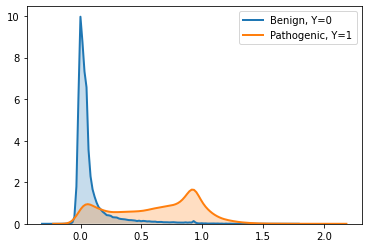

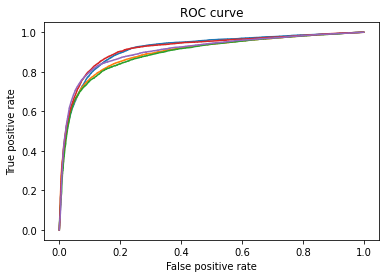

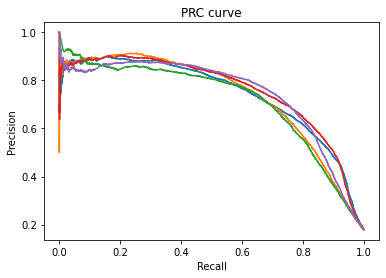

Time taken for this model 1186.7720301151276
===============Finished===============
==========Starting for h = 1==========
========Cross Validation: 1/5========
Epoch 1/1000
23/23 - 2s - loss: 1.3650 - accuracy: 0.1791 - val_loss: 0.3505 - val_accuracy: 0.1789
Epoch 2/1000
23/23 - 1s - loss: 0.6311 - accuracy: 0.1797 - val_loss: 0.2932 - val_accuracy: 0.1803
Epoch 3/1000
23/23 - 1s - loss: 0.3772 - accuracy: 0.1811 - val_loss: 0.2947 - val_accuracy: 0.1797
Epoch 4/1000
23/23 - 1s - loss: 0.2595 - accuracy: 0.4431 - val_loss: 0.2863 - val_accuracy: 0.1790
Epoch 5/1000
23/23 - 1s - loss: 0.1932 - accuracy: 0.8232 - val_loss: 0.2923 - val_accuracy: 0.1788
Epoch 6/1000
23/23 - 1s - loss: 0.1630 - accuracy: 0.8291 - val_loss: 0.2885 - val_accuracy: 0.1788
Epoch 7/1000
23/23 - 1s - loss: 0.1483 - accuracy: 0.8297 - val_loss: 0.2769 - val_accuracy: 0.1788
Epoch 8/1000
23/23 - 1s - loss: 0.1407 - accuracy: 0.8301 - val_loss: 0.2663 - val_accuracy: 0.1788
Epoch 9/1000
23/23 - 1s - loss: 0.1372 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:69: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


========Cross Validation: 3/5========
Epoch 1/1000
23/23 - 2s - loss: 1.2434 - accuracy: 0.1790 - val_loss: 0.2816 - val_accuracy: 0.1818
Epoch 2/1000
23/23 - 1s - loss: 0.5604 - accuracy: 0.1789 - val_loss: 0.2798 - val_accuracy: 0.1786
Epoch 3/1000
23/23 - 1s - loss: 0.3980 - accuracy: 0.1790 - val_loss: 0.2823 - val_accuracy: 0.1785
Epoch 4/1000
23/23 - 1s - loss: 0.3094 - accuracy: 0.1802 - val_loss: 0.2958 - val_accuracy: 0.1785
Epoch 5/1000
23/23 - 1s - loss: 0.2461 - accuracy: 0.5473 - val_loss: 0.3004 - val_accuracy: 0.1785
Epoch 6/1000
23/23 - 1s - loss: 0.1997 - accuracy: 0.8208 - val_loss: 0.2978 - val_accuracy: 0.1785
Epoch 7/1000
23/23 - 1s - loss: 0.1676 - accuracy: 0.8244 - val_loss: 0.2944 - val_accuracy: 0.1785
Epoch 8/1000
23/23 - 1s - loss: 0.1472 - accuracy: 0.8294 - val_loss: 0.2915 - val_accuracy: 0.1785
Epoch 9/1000
23/23 - 1s - loss: 0.1359 - accuracy: 0.8364 - val_loss: 0.2911 - val_accuracy: 0.1785
Epoch 10/1000
23/23 - 1s - loss: 0.1301 - accuracy: 0.8399 - v

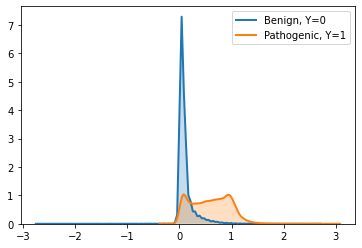

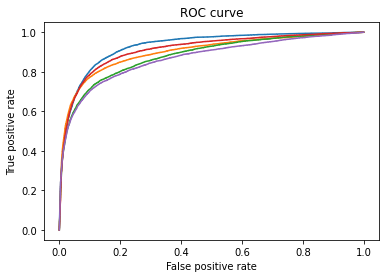

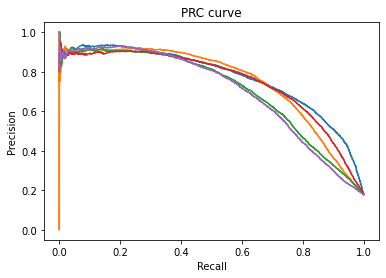

Time taken for this model 905.6145594120026
===============Finished===============
==========Starting for h = 2==========
========Cross Validation: 1/5========
Epoch 1/1000
23/23 - 2s - loss: 1.0471 - accuracy: 0.1789 - val_loss: 0.2997 - val_accuracy: 0.1788
Epoch 2/1000
23/23 - 1s - loss: 0.4420 - accuracy: 0.1789 - val_loss: 0.3878 - val_accuracy: 0.1788
Epoch 3/1000
23/23 - 1s - loss: 0.3230 - accuracy: 0.1791 - val_loss: 0.3938 - val_accuracy: 0.1788
Epoch 4/1000
23/23 - 1s - loss: 0.2521 - accuracy: 0.4810 - val_loss: 0.3614 - val_accuracy: 0.1788
Epoch 5/1000
23/23 - 1s - loss: 0.2036 - accuracy: 0.8221 - val_loss: 0.3230 - val_accuracy: 0.1788
Epoch 6/1000
23/23 - 1s - loss: 0.1704 - accuracy: 0.8281 - val_loss: 0.2906 - val_accuracy: 0.1788
Epoch 7/1000
23/23 - 1s - loss: 0.1516 - accuracy: 0.8317 - val_loss: 0.2644 - val_accuracy: 0.1788
Epoch 8/1000
23/23 - 1s - loss: 0.1418 - accuracy: 0.8321 - val_loss: 0.2451 - val_accuracy: 0.7564
Epoch 9/1000
23/23 - 1s - loss: 0.1360 -

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:69: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


========Cross Validation: 3/5========
Epoch 1/1000
23/23 - 2s - loss: 1.0883 - accuracy: 0.1790 - val_loss: 0.2969 - val_accuracy: 0.1785
Epoch 2/1000
23/23 - 1s - loss: 0.4313 - accuracy: 0.1790 - val_loss: 0.3594 - val_accuracy: 0.1785
Epoch 3/1000
23/23 - 1s - loss: 0.3088 - accuracy: 0.1811 - val_loss: 0.3741 - val_accuracy: 0.1785
Epoch 4/1000
23/23 - 1s - loss: 0.2324 - accuracy: 0.6842 - val_loss: 0.3388 - val_accuracy: 0.1785
Epoch 5/1000
23/23 - 1s - loss: 0.1865 - accuracy: 0.8211 - val_loss: 0.2959 - val_accuracy: 0.1785
Epoch 6/1000
23/23 - 1s - loss: 0.1628 - accuracy: 0.8211 - val_loss: 0.2593 - val_accuracy: 0.1786
Epoch 7/1000
23/23 - 1s - loss: 0.1490 - accuracy: 0.8211 - val_loss: 0.2278 - val_accuracy: 0.8215
Epoch 8/1000
23/23 - 1s - loss: 0.1436 - accuracy: 0.8263 - val_loss: 0.2044 - val_accuracy: 0.8215
Epoch 9/1000
23/23 - 1s - loss: 0.1413 - accuracy: 0.8297 - val_loss: 0.1867 - val_accuracy: 0.8215
Epoch 10/1000
23/23 - 1s - loss: 0.1398 - accuracy: 0.8297 - v

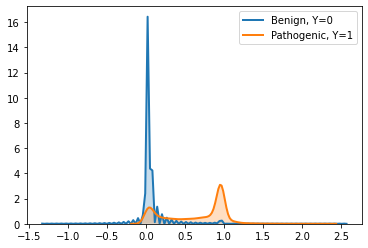

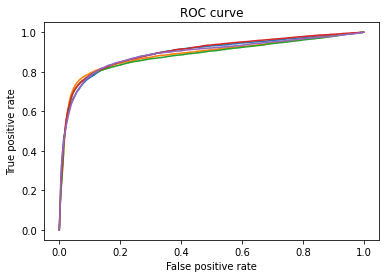

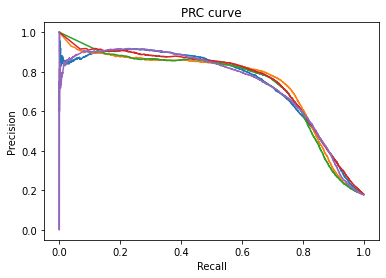

Time taken for this model 1376.9490065574646
===============Finished===============
==========Starting for h = 2==========
========Cross Validation: 1/5========
Epoch 1/1000
23/23 - 2s - loss: 0.8794 - accuracy: 0.1835 - val_loss: 0.3494 - val_accuracy: 0.1800
Epoch 2/1000
23/23 - 1s - loss: 0.3942 - accuracy: 0.1869 - val_loss: 0.5012 - val_accuracy: 0.1788
Epoch 3/1000
23/23 - 1s - loss: 0.2888 - accuracy: 0.2344 - val_loss: 0.4702 - val_accuracy: 0.1788
Epoch 4/1000
23/23 - 2s - loss: 0.2235 - accuracy: 0.7674 - val_loss: 0.4184 - val_accuracy: 0.1788
Epoch 5/1000
23/23 - 1s - loss: 0.1793 - accuracy: 0.8298 - val_loss: 0.3757 - val_accuracy: 0.1788
Epoch 6/1000
23/23 - 2s - loss: 0.1556 - accuracy: 0.8312 - val_loss: 0.3492 - val_accuracy: 0.1788
Epoch 7/1000
23/23 - 2s - loss: 0.1450 - accuracy: 0.8351 - val_loss: 0.3317 - val_accuracy: 0.1788
Epoch 8/1000
23/23 - 2s - loss: 0.1387 - accuracy: 0.8381 - val_loss: 0.3210 - val_accuracy: 0.1789
Epoch 9/1000
23/23 - 2s - loss: 0.1337 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:69: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


========Cross Validation: 3/5========
Epoch 1/1000
23/23 - 2s - loss: 0.8892 - accuracy: 0.1789 - val_loss: 0.3276 - val_accuracy: 0.1785
Epoch 2/1000
23/23 - 1s - loss: 0.4072 - accuracy: 0.1789 - val_loss: 0.4439 - val_accuracy: 0.1785
Epoch 3/1000
23/23 - 1s - loss: 0.3089 - accuracy: 0.1792 - val_loss: 0.4320 - val_accuracy: 0.1785
Epoch 4/1000
23/23 - 2s - loss: 0.2399 - accuracy: 0.6102 - val_loss: 0.3769 - val_accuracy: 0.1785
Epoch 5/1000
23/23 - 2s - loss: 0.1907 - accuracy: 0.8247 - val_loss: 0.3254 - val_accuracy: 0.1785
Epoch 6/1000
23/23 - 2s - loss: 0.1609 - accuracy: 0.8265 - val_loss: 0.2841 - val_accuracy: 0.1785
Epoch 7/1000
23/23 - 2s - loss: 0.1458 - accuracy: 0.8318 - val_loss: 0.2524 - val_accuracy: 0.1800
Epoch 8/1000
23/23 - 2s - loss: 0.1385 - accuracy: 0.8356 - val_loss: 0.2328 - val_accuracy: 0.8215
Epoch 9/1000
23/23 - 2s - loss: 0.1334 - accuracy: 0.8375 - val_loss: 0.2154 - val_accuracy: 0.8215
Epoch 10/1000
23/23 - 2s - loss: 0.1298 - accuracy: 0.8392 - v

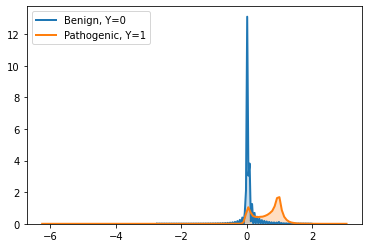

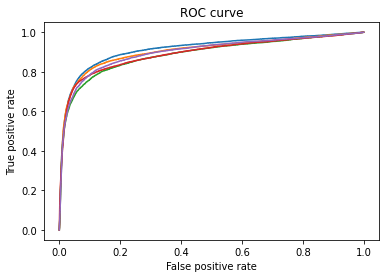

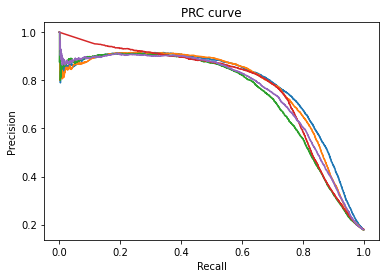

Time taken for this model 1187.9461646080017
===============Finished===============
==========Starting for h = 4==========
========Cross Validation: 1/5========
Epoch 1/1000
23/23 - 3s - loss: 0.9968 - accuracy: 0.1791 - val_loss: 0.3919 - val_accuracy: 0.1788
Epoch 2/1000
23/23 - 2s - loss: 0.3792 - accuracy: 0.1797 - val_loss: 0.4981 - val_accuracy: 0.1788
Epoch 3/1000
23/23 - 2s - loss: 0.2545 - accuracy: 0.4765 - val_loss: 0.4730 - val_accuracy: 0.1788
Epoch 4/1000
23/23 - 2s - loss: 0.1969 - accuracy: 0.8230 - val_loss: 0.4248 - val_accuracy: 0.1788
Epoch 5/1000
23/23 - 2s - loss: 0.1678 - accuracy: 0.8279 - val_loss: 0.3841 - val_accuracy: 0.1788
Epoch 6/1000
23/23 - 2s - loss: 0.1525 - accuracy: 0.8318 - val_loss: 0.3601 - val_accuracy: 0.1788
Epoch 7/1000
23/23 - 2s - loss: 0.1457 - accuracy: 0.8336 - val_loss: 0.3434 - val_accuracy: 0.1788
Epoch 8/1000
23/23 - 2s - loss: 0.1387 - accuracy: 0.8359 - val_loss: 0.3289 - val_accuracy: 0.1788
Epoch 9/1000
23/23 - 2s - loss: 0.1365 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:69: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


========Cross Validation: 3/5========
Epoch 1/1000
23/23 - 3s - loss: 0.7180 - accuracy: 0.1831 - val_loss: 0.3683 - val_accuracy: 0.1786
Epoch 2/1000
23/23 - 2s - loss: 0.2734 - accuracy: 0.3783 - val_loss: 0.4141 - val_accuracy: 0.1785
Epoch 3/1000
23/23 - 2s - loss: 0.2014 - accuracy: 0.8213 - val_loss: 0.3784 - val_accuracy: 0.1785
Epoch 4/1000
23/23 - 2s - loss: 0.1649 - accuracy: 0.8265 - val_loss: 0.3276 - val_accuracy: 0.1785
Epoch 5/1000
23/23 - 2s - loss: 0.1474 - accuracy: 0.8306 - val_loss: 0.2911 - val_accuracy: 0.1785
Epoch 6/1000
23/23 - 2s - loss: 0.1379 - accuracy: 0.8341 - val_loss: 0.2633 - val_accuracy: 0.1785
Epoch 7/1000
23/23 - 2s - loss: 0.1294 - accuracy: 0.8399 - val_loss: 0.2387 - val_accuracy: 0.8215
Epoch 8/1000
23/23 - 2s - loss: 0.1229 - accuracy: 0.8472 - val_loss: 0.2175 - val_accuracy: 0.8215
Epoch 9/1000
23/23 - 2s - loss: 0.1157 - accuracy: 0.8540 - val_loss: 0.2038 - val_accuracy: 0.8215
Epoch 10/1000
23/23 - 2s - loss: 0.1117 - accuracy: 0.8599 - v

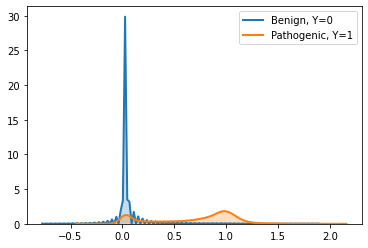

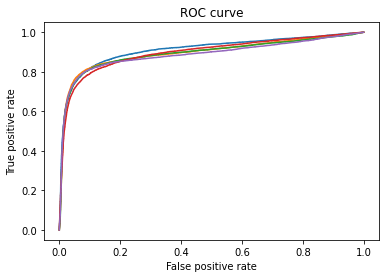

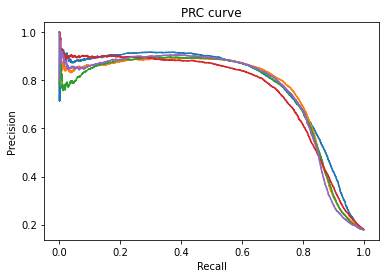

Time taken for this model 1753.0143911838531
===============Finished===============
==========Starting for h = 4==========
========Cross Validation: 1/5========
Epoch 1/1000
23/23 - 3s - loss: 0.7105 - accuracy: 0.2268 - val_loss: 0.3787 - val_accuracy: 0.1835
Epoch 2/1000
23/23 - 2s - loss: 0.2682 - accuracy: 0.4802 - val_loss: 0.4256 - val_accuracy: 0.1788
Epoch 3/1000
23/23 - 2s - loss: 0.1757 - accuracy: 0.8247 - val_loss: 0.3832 - val_accuracy: 0.1788
Epoch 4/1000
23/23 - 2s - loss: 0.1454 - accuracy: 0.8297 - val_loss: 0.3474 - val_accuracy: 0.1788
Epoch 5/1000
23/23 - 2s - loss: 0.1317 - accuracy: 0.8371 - val_loss: 0.3170 - val_accuracy: 0.1788
Epoch 6/1000
23/23 - 2s - loss: 0.1195 - accuracy: 0.8477 - val_loss: 0.3024 - val_accuracy: 0.1788
Epoch 7/1000
23/23 - 2s - loss: 0.1093 - accuracy: 0.8595 - val_loss: 0.2832 - val_accuracy: 0.1788
Epoch 8/1000
23/23 - 2s - loss: 0.1035 - accuracy: 0.8687 - val_loss: 0.2696 - val_accuracy: 0.1819
Epoch 9/1000
23/23 - 2s - loss: 0.0939 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:69: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


========Cross Validation: 3/5========
Epoch 1/1000
23/23 - 3s - loss: 0.8828 - accuracy: 0.2413 - val_loss: 0.4714 - val_accuracy: 0.1788
Epoch 2/1000
23/23 - 2s - loss: 0.3667 - accuracy: 0.2142 - val_loss: 0.5427 - val_accuracy: 0.1786
Epoch 3/1000
23/23 - 2s - loss: 0.2491 - accuracy: 0.5316 - val_loss: 0.4972 - val_accuracy: 0.1785
Epoch 4/1000
23/23 - 2s - loss: 0.1908 - accuracy: 0.8214 - val_loss: 0.4442 - val_accuracy: 0.1785
Epoch 5/1000
23/23 - 2s - loss: 0.1594 - accuracy: 0.8311 - val_loss: 0.4114 - val_accuracy: 0.1785
Epoch 6/1000
23/23 - 2s - loss: 0.1407 - accuracy: 0.8378 - val_loss: 0.3925 - val_accuracy: 0.1785
Epoch 7/1000
23/23 - 2s - loss: 0.1274 - accuracy: 0.8456 - val_loss: 0.3897 - val_accuracy: 0.1785
Epoch 8/1000
23/23 - 2s - loss: 0.1177 - accuracy: 0.8541 - val_loss: 0.3938 - val_accuracy: 0.1785
Epoch 9/1000
23/23 - 2s - loss: 0.1108 - accuracy: 0.8611 - val_loss: 0.4028 - val_accuracy: 0.1785
Epoch 10/1000
23/23 - 2s - loss: 0.1036 - accuracy: 0.8685 - v

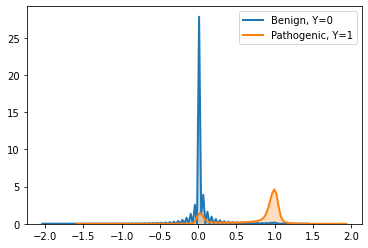

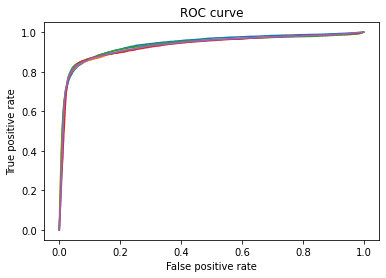

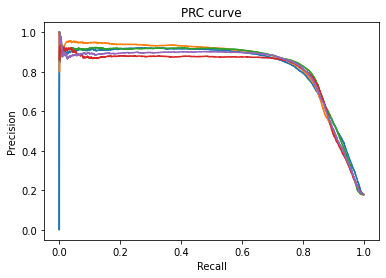

Time taken for this model 1783.815331697464
===============Finished===============
Total time taken 8194.113162279129


NameError: ignored

In [4]:
# best_h_acc = -1  # best h value when chosen based on the validation accuracy.
# best_acc = 0
best_h_auc = -1  # best h value when chosen based on the validation auc value.
best_auc = 0
best_pred = ""
best_model_maker = get_model

over_all_start_time = time.time()

for model_maker in [get_model, get_model2]:
    print("===========Next model type============")
    for h in [1, 2, 4]:
        start_time = time.time()
        print("==========Starting for h =", str(h) + "==========")

        metrics = k_fold_cross_validation(h, X, Y, k=5, epochs=epochs, batch_size=batch_size, callbacks=[early_stopping_callback], get_model=model_maker)

        print(metrics["model_summary"])

        print("Final metrics for this model")
        print("Average of the final training set accuracy over all folds =", str(metrics["avg_accuracy_train"]))
        print("Average of the final training set loss over all folds =", str(metrics["avg_loss_train"]))
        print("Average of the final validation set accuracy over all folds =", str(metrics["avg_accuracy_val"]))
        print("Average of the final validation set loss over all folds =", str(metrics["avg_loss_val"]))
        print("Average of the ROC AUC over all folds =", str(metrics["avg_roc_auc"]))
        pred = metrics["predictions"]
        print("Genes with both pathogenic and benign mutations:")
        print(genes_with_both(gene_ids, Y, pred))
        draw_pdf(Y, pred)

        for c in metrics["roc"]: plt.plot(*c)
        plt.xlabel('False positive rate')
        plt.ylabel('True positive rate')
        plt.title('ROC curve')
        plt.show()

        for c in metrics["prc"]: plt.plot(*c)
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('PRC curve')
        plt.show()

        # if metrics["avg_accuracy_val"] > best_acc:
        #     best_h_acc = h
        #     best_acc = metrics["avg_accuracy_val"]

        if metrics["avg_roc_auc"] > best_auc:
            best_h_auc = h
            best_auc = metrics["avg_roc_auc"]
            best_pred = pred
            best_model_maker = model_maker

        print("Time taken for this model", str(time.time() - start_time))

        print("===============Finished===============")

print("Total time taken", str(time.time() - over_all_start_time))
# print("The h value for the best validation accuracy is", str(best_h_acc), "and the corresponding accuracy is", str(best_acc))
print("The h value for the best auc is", str(best_h_auc), "and the corresponding auc is", str(best_auc))

Now training the best model architecture using the whole data

In [0]:
model = best_model_maker(best_h_auc)
history = model.fit(X, Y, batch_size=batch_size, epochs=epochs)

plt.plot(history.history['accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

plot_model(model, to_file='model.png')
model.summary()
model.save("model.h5")